<a href="https://colab.research.google.com/github/my000own000files1/Fuzzy/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [246]:
# Автоматизация расчета уравнения состояния объекта с помощью пакета sympy
import sympy,math

#создаем символьные переменные
m=sympy.symbols('m')
M=sympy.symbols('M')
g=sympy.symbols('g')
L=sympy.symbols('L')
k1=sympy.symbols('k1')
k2=sympy.symbols('k2')
Fe=sympy.symbols('Fe')
x=sympy.symbols('x')
dx=sympy.symbols('dx')
phi=sympy.symbols('phi')
dphi=sympy.symbols('dphi')

ddx=sympy.symbols('ddx')
ddphi=sympy.symbols('ddphi')
#signdx=sympy.symbols('np.sign(dx)')

# полная кинетическая системы T
T = m*(dx**2+(L**2)*dphi**2+2*dx*L*dphi*sympy.cos(phi))/2+M*(dx**2)/2
# полная потенциальная энергися системы V
V = (k1*(L*dphi)*sympy.sin(phi)-m*g)*L*sympy.cos(phi)
#задание функции Лагранжа
L = T - V
print("L=",L)
#правая часть 1-ого уравнения ЭЛ
Fx=Fe-k2*dx 
#Система уравнений Эйлера-Лагранжа 2 рода
dLddx=sympy.diff(L,dx)
print(dLddx)
L1=(sympy.diff(dLddx,x)*dx+sympy.diff(dLddx,dx)*ddx+sympy.diff(dLddx,phi)*dphi+sympy.diff(dLddx,dphi)*ddphi)-(sympy.diff(L,x))-Fx #L[0]=0
print("L1=",L1,"=0")
dLddphi=sympy.diff(L,dphi)
print("dL/d(dphi)=",dLddphi)
dLdphi=sympy.diff(L,phi)
print("dLdphi=",dLdphi)
ddLddphidt=(sympy.diff(dLddphi,x)*dx+sympy.diff(dLddphi,dx)*ddx+sympy.diff(dLddphi,phi)*dphi+sympy.diff(dLddphi,dphi)*ddphi)
print("d( dL/d(dphi) )/dt=",ddLddphidt)
L2=ddLddphidt-dLdphi +k1*dphi*L*sympy.cos(phi) #L[1]=0
print("L2=",L2,"=0")
Leqzero=L1-L2
#разрешим относительно ddx
#ddx=sympy.solve(L1,ddx)
#ddphi=sympy.solve(Leqzero,ddphi)
#ddx=sympy.solve(Leqzero,ddx)
ddphi=sympy.solve(L2,ddphi)
print("ddphi=",ddphi,"\n")
#print(L1.subs('ddphi',ddphi[0]))
ddx=sympy.solve(L1.subs('ddphi',ddphi[0]),ddx)
ddx = sympy.simplify(ddx[0])
print("ddx=",ddx,"\n","ddphi=",ddphi[0])

L= -L*(L*dphi*k1*sin(phi) - g*m)*cos(phi) + M*dx**2/2 + m*(L**2*dphi**2 + 2*L*dphi*dx*cos(phi) + dx**2)/2
M*dx + m*(2*L*dphi*cos(phi) + 2*dx)/2
L1= -Fe + L*ddphi*m*cos(phi) - L*dphi**2*m*sin(phi) + ddx*(M + m) + dx*k2 =0
dL/d(dphi)= -L**2*k1*sin(phi)*cos(phi) + m*(2*L**2*dphi + 2*L*dx*cos(phi))/2
dLdphi= -L**2*dphi*k1*cos(phi)**2 - L*dphi*dx*m*sin(phi) + L*(L*dphi*k1*sin(phi) - g*m)*sin(phi)
d( dL/d(dphi) )/dt= L**2*ddphi*m + L*ddx*m*cos(phi) + dphi*(L**2*k1*sin(phi)**2 - L**2*k1*cos(phi)**2 - L*dx*m*sin(phi))
L2= L**2*ddphi*m + L**2*dphi*k1*cos(phi)**2 + L*ddx*m*cos(phi) + L*dphi*dx*m*sin(phi) - L*(L*dphi*k1*sin(phi) - g*m)*sin(phi) + dphi*k1*(-L*(L*dphi*k1*sin(phi) - g*m)*cos(phi) + M*dx**2/2 + m*(L**2*dphi**2 + 2*L*dphi*dx*cos(phi) + dx**2)/2)*cos(phi) + dphi*(L**2*k1*sin(phi)**2 - L**2*k1*cos(phi)**2 - L*dx*m*sin(phi)) =0
ddphi= [-dphi**3*k1*cos(phi)/2 + dphi**2*k1**2*sin(phi)*cos(phi)**2/m - ddx*cos(phi)/L - dphi**2*dx*k1*cos(phi)**2/L - dphi*g*k1*cos(phi)**2/L - g*sin(phi)/L - M*

In [38]:
!pip install -U scikit-fuzzy

Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.7/dist-packages (0.4.2)


In [39]:
  !pip install -U control

Requirement already up-to-date: control in /usr/local/lib/python3.7/dist-packages (0.9.0)


In [40]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import control as ct
from control.matlab import * #I want to have a MATLAB-like environment
import matplotlib.pyplot as plt

In [267]:
#creating object dynamics
def port_crane_updfcn(t,s,u,params):
  """A port crane with a cargo on a rope dynamics (like object) 
  assumptions: by all perturbations such as the rolling friction
   force at the point of contact with the rails, air resistance,
    we also assume that the cable is inextensible, i.e. L=const

  Parameters
  ----------
  s: array 
      System state: [x,dx,phi,dphi], where x is a port crane (object) position
      in [0,200] [m], dx is velocity of the port crane in m/s, phi is an angle
      of deflection of the rope with a container, which is a cargo and attached
      to the end of the rope in rad, dphi is angular velocity of the rope 
      deflection in rad/sec

  u: array
      System inputs: [Fe], where Fe is a pulling force exerted on the
      trolley (cart), created by electric motor in Newton

  Returns 
  -------
  float
      [ddx,ddphi], where ddx is a port crane acceleration in m/s^2 and ddphi is 
      angular acceleration in rad/s^2
  """
  from math import sin,cos

  # Set up the system parameters
  m = params.get('m', 400.)  # cargo mass in kg
  M = params.get('M', 3000.) # port crane mass in kg
  g = params.get('g', 9.8)    # gravitational constant, m/s^2
  L = params.get('L', 30.)     # length of the drope in m
  k1 = params.get('k1', 8e-1)    # static coefficient of viscous friction air acting on port crane cart in 1/kg
  k2 = params.get('k2',1.5e3)     # static coefficient of friction acting on cargo, it's include viscous friction air and dry friction and other that depend on speed in 1/kg

  # Define variables for object state
  x = s[0]    # port crane position in m
  dx = s[1]   # velocity of the port crane in m/s
  phi = s[2]  # deflection of the rope angle in rad
  dphi = s[3] # angular velocity of the rope deflection in rad/sec

  #Define variables for object inputs
  Fe = u[0]   # pulling force exerted on the trolley in Newtons

  # calculating the output variables
  ddx = (Fe*L + L**2*dphi**3*k1*m*cos(phi)**2/2 - L**2*dphi**2*k1**2*sin(phi)*cos(phi)**3 + L**2*dphi**2*m*sin(phi) + L*dphi**2*dx*k1*m*cos(phi)**3 + L*dphi*g*k1*m*cos(phi)**3 - L*dx*k2 + L*g*m*sin(2*phi)/2 + M*dphi*dx**2*k1*cos(phi)**2/2 + dphi*dx**2*k1*m*cos(phi)**2/2)/(L*(M + m*sin(phi)**2)) 
  ddphi = -dphi**3*k1*cos(phi)/2 + dphi**2*k1**2*sin(phi)*cos(phi)**2/m - ddx*cos(phi)/L - dphi**2*dx*k1*cos(phi)**2/L - dphi*g*k1*cos(phi)**2/L - g*sin(phi)/L - M*dphi*dx**2*k1*cos(phi)/(2*L**2*m) - dphi*dx**2*k1*cos(phi)/(2*L**2)

  return np.array([dx,ddx,dphi,ddphi])

def port_crane_outfcn(t, s, u, params):
  return s[0:3]

In [151]:
# Define a generator for creating a plots
def system_dynamic_plot(sys, t, y, u, t_start_input=0, x_ref=0, linetype='b-',
                         subplots=[None, None, None],fig_size=None):
  #Figure out the plot bounds and indices
  x_min = 0; x_max = x_ref+math.ceil(x_ref*0.05); x_ind = sys.find_state('x')
  phi_min = -math.pi/18; phi_max = math.pi/18; phi_ind = sys.find_state('phi')
  Fe_min = 0; Fe_max = max(u); Fe_ind = sys.find_input('Fe') 

  #convert phi from rad to deg
  from math import pi 
  y[phi_ind]*=180/pi

  # Make sure the upper and lower bounds on x are OK
  while max(y[x_ind]) > x_max: x_max += 1
  while min(y[x_ind]) < x_min: x_min -= 1

  # Make sure the upper and lower bounds on phi are OK
  while max(y[phi_ind]) > phi_max: phi_max += 1
  while min(y[phi_ind]) < phi_min: phi_min -= 1
  phi_max+=1
  phi_min-=1

  # Make sure the upper and lower bounds on Fe are OK
  if len(u.shape)>1:
    while max(u[Fe_ind]) > Fe_max: Fe_max += 1
    while min(u[Fe_ind]) < Fe_min: Fe_min -= 1
  else:
    while max(u) > Fe_max: Fe_max += 1
    while min(u) < Fe_min: Fe_min -= 1
  Fe_max += Fe_max*0.1

  # Create arrays for return values
  subplot_axes = subplots.copy()

  # Position profile
  if subplot_axes[0] is None:
    subplot_axes[0] = plt.subplot(3,1,1)
  else:
    plt.sca(subplots[0])
  plt.plot(t, y[x_ind], linetype)
  plt.plot(t, x_ref*np.ones(t.shape), 'k-')
  plt.plot([t_start_input, t_start_input], [x_min, x_max], 'k--')
  plt.axis([0, t[-1], x_min, x_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('Port crane \nposition $x$')
  plt.grid(color='0.5')
  
  # Angle phi profile
  if subplot_axes[1] is None:
    subplot_axes[1] = plt.subplot(3,1,2)
  else:
    plt.sca(subplots[1])
  plt.plot(t, y[phi_ind], linetype)
  plt.plot([t_start_input, t_start_input], [phi_min, phi_max], 'k--')
  plt.axis([0, t[-1], phi_min, phi_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('deflection of the\n rope angle\n $\phi$ in $\circ$')
  plt.grid(color='0.5')

  # Pulling force
  if subplot_axes[2] is None:
    subplot_axes[2] = plt.subplot(3,1,3)
  else:
    plt.sca(subplots[2])
  if len(u.shape)>1:
    plt.plot(t, u[Fe_ind], linetype)
  else:
    plt.plot(t, u, linetype)
  plt.plot([t_start_input, t_start_input], [Fe_min, Fe_max], 'k--')
  plt.axis([0, t[-1], Fe_min, Fe_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('pulling force Fe,\n $Newton$')
  plt.grid(color='0.5')
  
  return subplot_axes

In [268]:
#Input/ouput model for the object
sys_object = ct.NonlinearIOSystem(port_crane_updfcn, port_crane_outfcn, 
                   inputs = ('Fe'), outputs = None, states=('x','dx','phi','dphi'),
                   name='sys_object',params={})

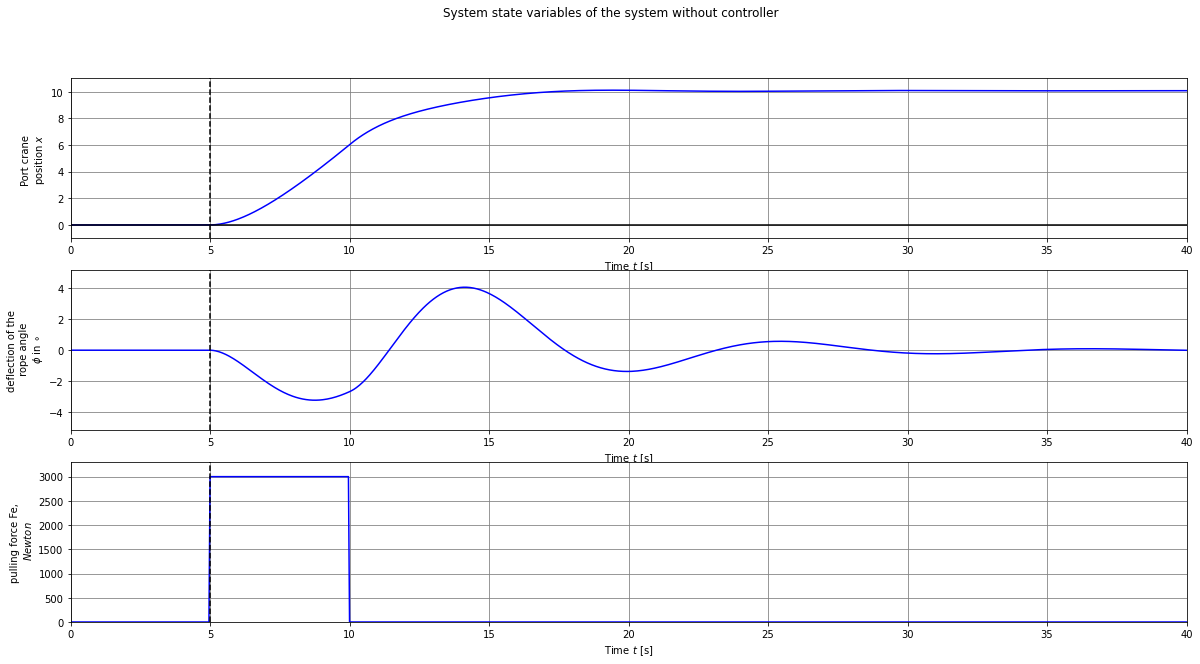

In [272]:
# Define the generator for simulating an aoutonomus object whithout
# controller, when state var equal to null. And also Fe = constant

# Define the time and input vectors
# Force starts from (time_start_force) sec and continue during  (time_application_of_force) sec of
# interval and than force become zero before the end of tine interval 
time_start_force=5
time_application_of_force = 5
time_interval_stop = 40 # length of time interval in sec 
T = np.linspace(0, time_interval_stop, 1000+1)
N_time_start_force = math.ceil((time_start_force/time_interval_stop)*(len(T)-1))
N_time_application_of_force = math.ceil((time_application_of_force/time_interval_stop)*(len(T)-1))
Fe = 3e3*np.concatenate(( np.zeros(N_time_start_force),
            np.ones(N_time_application_of_force),
            np.zeros(len(T)-N_time_start_force-N_time_application_of_force) ))
#xref = 120*np.zeros(T.shape)
#phiref

# Find the eruilibrium point for the system
#Xeq, Phieq = ct.find_eqpt(
#    sys_object, [xref[0]]
#)

init_state_vars = [0,0,0,0] #[dx,ddx,dphi,ddphi]
# Response of the system with no integral feedback term
figsize=(20,10)
plt.figure(figsize=figsize)  
t, y_sfb = ct.input_output_response(sys_object, T, [Fe],init_state_vars,params={})
subplots = system_dynamic_plot(sys_object, t, y_sfb, u=Fe,
         t_start_input=time_start_force, linetype='-b',fig_size=figsize)

# Add title and legend
plt.suptitle('System state variables of the system without controller')
import matplotlib.lines as mlines
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='without controller')

In [126]:
#from sympy import Piecewise
c=sympy.symbols('c')
d=sympy.symbols('d')
a= sympy.Piecewise((c+d, c==4 ) ,(c-d,True))
c=2
d=4
print(a.subs({'c':c,'d':d}) )

-2
5.71672847093920


In [168]:

print(ddx[0].evalf(subs={ 'x':3,'dx':2,'phi':2,'dphi':2,'m':230,'M':6000,'k1':0,'k2':0,'g':9.8,'L':30,'Fe':800 }))

2.14258499040039


In [109]:
type(a)

sympy.core.add.Add

In [ ]:
def port_crane_outdcn(t ,x ,u , param={})
  # Get the port crane parameters that we need
  